# Imports

In [15]:
#Pre-processing
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm

tqdm.pandas()

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp
from sklearn.model_selection import train_test_split
from sklearn import tree

# Data

In [351]:
df=pd.read_csv("dfFifaPrep.csv",sep=";")
df=df.drop("Unnamed: 0", axis=1)

In [352]:
df.head()

,player_international,number,Nationalite,mois_de_naissance,jour_de_naissance,anne_de_naissance,age_actuel,taille_en_m,Poste,Pied_fort,...,Agility,Penalties,Volleys,Power,Jumping,Heading,Curve,Injury,Finishing,value
0,True,26,Français,janvier,26,1993.0,29.0,"1,79",Milieu,Gauche,...,84.0,78.0,75.0,NaN,76.0,70.0,84.0,NaN,72.0,"10,00 mio. €"
1,True,14,Néerlandais,février,13,1994.0,28.0,"1,78",Attaquant,Droit,...,80.0,76.0,75.0,NaN,69.0,65.0,85.0,NaN,84.0,"20,00 mio. €"
2,True,10,Brésilien,février,5,1992.0,30.0,"1,75",Attaquant,Droit,...,93.0,91.0,86.0,NaN,62.0,63.0,88.0,Prone,83.0,"75,00 mio. €"
3,True,45,Ghanéen Italien (depuis 2008)[2],août,12,1990.0,32.0,"1,89",Attaquant,Droit,...,68.0,91.0,78.0,Free-Kick,72.0,72.0,76.0,Prone,80.0,"2,00 mio. €"
4,True,8,Français Algérien,juillet,18,1993.0,29.0,"1,73",Milieu,Gauche,...,85.0,74.0,77.0,Free-Kick,64.0,49.0,83.0,NaN,83.0,"40,00 mio. €"


In [353]:
df.dtypes

player_international       bool
number                   object
Nationalite              object
mois_de_naissance        object
jour_de_naissance         int64
anne_de_naissance       float64
age_actuel              float64
taille_en_m              object
Poste                    object
Pied_fort                object
id                        int64
player_name              object
time                      int64
goals                     int64
xG                      float64
assists                   int64
xA                      float64
shots                     int64
key_passes                int64
yellow_cards              int64
red_cards                 int64
position                 object
team_title               object
npg                       int64
npxG                    float64
xGChain                 float64
xGBuildup               float64
Dribbling               float64
Marking                  object
Aggression              float64
Reactions               float64
Intercep

As we see, we have a lot of pre-processing to do, especially to convert string to int, and hot-one encode categorical values

In [8]:
cols_fiche_joueur=['id','number', 'player_name', 'Nationalite','dateDeNaissance','value', 'team_title', "Poste", "poste_group", "value"]
features=['id','player_international', 'age_actuel', 'taille_en_m', 'poste_cat', 'time', 'goals', 'xG',
       'assists', 'xA', 'shots', 'key_passes', 'yellow_cards', 'red_cards','npg', 'npxG', 'xGChain', 'xGBuildup',
       'Dribbling', 'Aggression', 'Reactions', 'Interceptions', 'Vision','Composure', 'Crossing', 'Acceleration', 'Strength', 'Agility',
       'Penalties', 'Volleys', 'Jumping', 'Heading', 'Curve','Finishing', 'power_cat', 'value_int']

# Pre-processing

Variables type conversions

In [355]:
##Define all formatting functions

#applied on row
def format_birthdate(row):
    months = {
                "janvier": 1,
                "février": 2,
                "mars": 3,
                "avril": 4,
                "mai": 5,
                "juin": 6,
                "juillet": 7,
                "août": 8,
                "septembre": 9,
                "octobre": 10,
                "novembre": 11,
                "décembre": 12
              }
    month = months[row['mois_de_naissance'].lower()]
    return datetime(int(row["anne_de_naissance"]), month, int(row["jour_de_naissance"]))

#applied on value
def format_pied(x):
    if x=="Droit":
        return 1
    if x=="Gauche":
        return -1
    if x=="Ambidextre":
        return 0

#applied on value
def format_pied(x):
    if x=="Droit":
        return 1
    if x=="Gauche":
        return -1
    if x=="Ambidextre":
        return 0

def format_player_value(x):
    if x=='-':
        return 454600064.26735216 # average market value
    value = x.split(" ")[0]
    value = value.replace(",", "")
    units = x.split(" ")[1]
    if units == "K":
        value = int(float(value) * 1000)
    elif units == "mio.":
        value = int(float(value) * 1000000)
    else:
        raise ValueError("Invalid monetary unit")

    return round(value)

def format_poste(x):
    if x=="Gardien de but":
        return 0
    if x=="Défenseur":
        return 1
    if x=="Arrière":
        return 2
    if x=="Latéral":
        return 3
    if x=="Milieu":
        return 4
    if x=="Ailier":
        return 5
    if x=="Attaquant":
        return 6
    if x=="Buteur":
        return 7

def format_poste_group(x):
    if x=="Gardien de but":
        return "Gardien de but"
    if x=="Défenseur":
        return "Défenseur"
    if x=="Arrière":
        return "Défenseur"
    if x=="Latéral":
        return "Défenseur"
    if x=="Milieu":
        return "Milieu"
    if x=="Ailier":
        return "Attaquant"
    if x=="Attaquant":
        return "Attaquant"
    if x=="Buteur":
        return "Attaquant"

def format_power(x):
    if x=='header':
        return 1
    if x=='Free-Kick':
        return 2
    else:
        return 0

def format_nationalite(x):
    if x[0] == ' ':
        x=x[1:]
    x=x.split(" ")
    return x[0]
        

In [356]:
#Strings to datetime
df["dateDeNaissance"]=df.apply(format_birthdate, axis=1)

#Boolean to int
df["player_international"]=df["player_international"].apply(lambda x: int(x))

#String to int
df["age_actuel"]=df["age_actuel"].apply(lambda x: int(x))
df['Nationalite']=df['Nationalite'].apply(format_nationalite)
df["taille_en_m"]=df["taille_en_m"].apply(lambda x: int(x.replace(",","")))
df["Pied_fort_cat"]=df["Pied_fort"].apply(format_pied)
df['position']=df['position'].apply(lambda x: x.split(' '))
df['value_int']=df['value'].apply(format_player_value)
df['poste_cat']=df['Poste'].apply(format_poste)
df['power_cat']=df["Power"].apply(format_power)
df['poste_group']=df["Poste"].apply(format_poste_group)


In [357]:
#Correct missing values
df=df.fillna(-1)
for feat in features:
    mean=df[feat].mean()
    df[feat]=df[feat].apply(lambda x: mean if x==-1 else x)

In [358]:
df.to_csv("df_preprocess.csv")

In [16]:
df=pd.read_csv("df_preprocess.csv")
df=df.drop("Unnamed: 0", axis=1)

As goalkeeper represent a very specific position, we take them out into a separated df

In [17]:
dfGK=df[df["Poste"]=="Gardien de but"]
dfRest=df[df["Poste"]!="Gardien de but"]

In [18]:
cols_fiche_joueur=['id','number', 'player_name', 'Nationalite','dateDeNaissance','value', 'team_title', "Poste", "poste_group", "value"]
features=['id','player_international', 'age_actuel', 'taille_en_m', 'poste_cat', 'time', 'goals', 'xG',
       'assists', 'xA', 'shots', 'key_passes', 'yellow_cards', 'red_cards','npg', 'npxG', 'xGChain', 'xGBuildup',
       'Dribbling', 'Aggression', 'Reactions', 'Interceptions', 'Vision','Composure', 'Crossing', 'Acceleration', 'Strength', 'Agility',
       'Penalties', 'Volleys', 'Jumping', 'Heading', 'Curve','Finishing', 'power_cat', 'value_int']

dfGK_fiche=pd.DataFrame(dfGK, columns=cols_fiche_joueur)
dfGK_features=pd.DataFrame(dfGK, columns=features)

dfRest_fiche=pd.DataFrame(dfRest, columns=cols_fiche_joueur)
dfRest_features=pd.DataFrame(dfRest, columns=features)

# DataViz

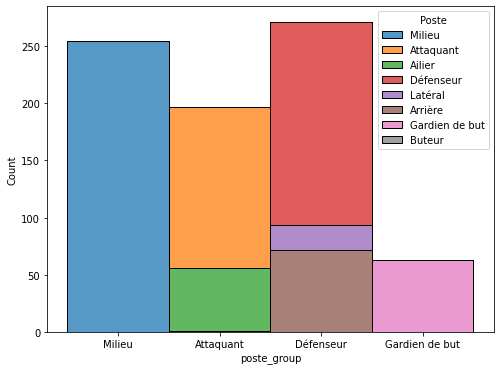

In [19]:
f, ax = plt.subplots(figsize=(8, 6))
g8=sns.histplot(x='poste_group', hue='Poste', multiple="stack", data=df)

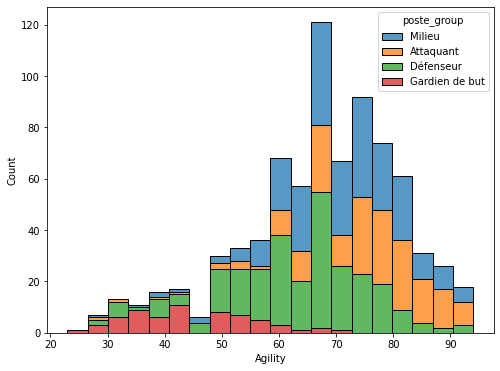

In [20]:
f, ax = plt.subplots(figsize=(8, 6))
g8=sns.histplot(x='Agility',
                hue='poste_group',
                multiple="stack",
                data=df)

In [21]:
df_plot1=pd.DataFrame(df, columns=["age_actuel", "value_int", "Poste"])
mean_value_per_poste = df.groupby(['Poste',"age_actuel"])['value_int'].mean().reset_index()

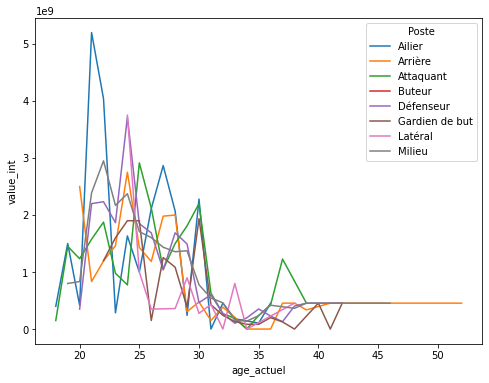

In [22]:
f, ax = plt.subplots(figsize=(8, 6))
g5=sns.lineplot(x='age_actuel', y='value_int', hue='Poste', data=mean_value_per_poste)

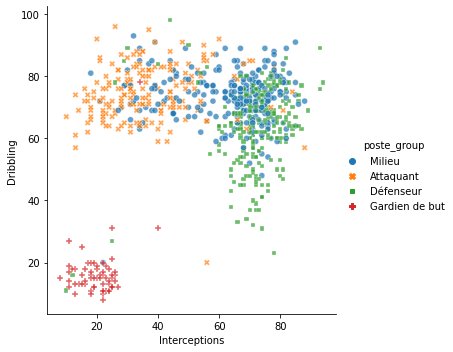

In [23]:
g = sns.relplot(x="Interceptions", 
                y="Dribbling", 
                hue="poste_group", 
                kind="scatter", 
                style = 'poste_group',
                data=df, 
                alpha = 0.7)

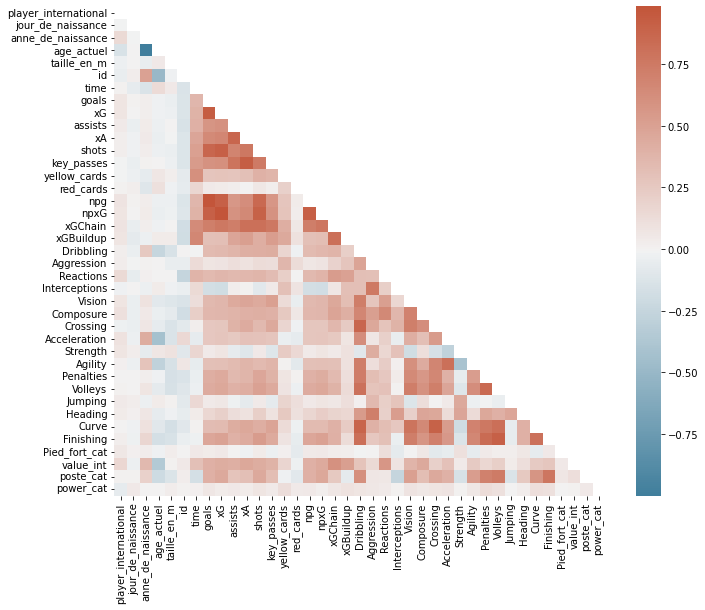

In [24]:
corr = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))

g2 = sns.heatmap(corr,cmap=cmap, mask=mask)

# Scaling

In [25]:
scalerGK = preprocessing.StandardScaler()
scalerGK.fit(dfGK_features.drop('id', axis=1))
dfGK_scaler=pd.DataFrame(scalerGK.transform(dfGK_features.drop('id', axis=1)))
dfGK_scaler["id"] = pd.Series(dfGK_features["id"].tolist())

In [26]:
scalerRest = preprocessing.StandardScaler()
scalerRest.fit(dfRest_features.drop('id', axis=1))
dfRest_scaler=pd.DataFrame(scalerRest.transform(dfRest_features.drop('id', axis=1)))
dfRest_scaler["id"]=pd.Series(dfRest_features["id"].tolist())
dfRest_scaler.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,id
0,0.345514,0.055539,0.363337,0.273812,1.610660,5.904901,4.702955,4.473061,5.925638,4.895448,...,1.215025,1.385043,1.195211,0.535937,0.477640,1.439412,0.831738,-0.155285,-0.097597,942
1,0.345514,-0.154405,0.345940,1.381331,1.191122,5.018859,3.395177,5.414209,3.216503,3.863840,...,0.886233,1.238967,1.195211,-0.029099,0.078318,1.507450,1.544430,-0.155285,0.510941,555
2,0.345514,0.265484,0.293749,1.381331,0.389431,5.018859,4.499782,5.414209,5.550123,3.191052,...,1.954807,2.334535,1.874109,-0.594135,-0.081411,1.711564,1.485039,-0.155285,3.857900,2099
3,0.345514,0.685374,0.537308,1.381331,0.900353,4.723512,3.991348,-0.232680,0.793959,3.953545,...,-0.100143,2.334535,1.380365,0.213059,0.637369,0.895106,1.306866,6.439766,-0.584428,1817
4,0.345514,0.055539,0.258955,0.273812,1.107007,4.723512,3.064240,3.061338,2.844438,3.056494,...,1.297223,1.092891,1.318647,-0.432696,-1.199512,1.371373,1.485039,6.439766,1.728017,3667


# PCA

In [27]:
pcaGK=PCA(n_components=3)
pcaGK.fit(dfGK_scaler.drop('id', axis=1))
dfGK_pca=pd.DataFrame(pcaGK.fit_transform(dfGK_scaler.drop('id', axis=1)))
dfGK_pca.columns=["PC1","PC2","PC3"]
dfGK_pca["id"]=pd.Series(dfGK_features["id"].tolist())

In [28]:
pcaRest=PCA(n_components=3)
pcaRest.fit(dfRest_scaler.drop('id', axis=1))
dfRest_pca=pd.DataFrame(pcaRest.fit_transform(dfRest_scaler.drop('id', axis=1)))
dfRest_pca.columns=["PC1","PC2","PC3"]
dfRest_pca["id"]=pd.Series(dfRest_features["id"].tolist())
dfRest_pca.head()

,PC1,PC2,PC3,id
0,13.303207,4.076445,5.165985,942
1,11.747988,2.102837,3.716046,555
2,14.903202,2.059482,2.410958,2099
3,7.187726,2.478135,4.451148,1817
4,10.798497,2.051687,1.734441,3667


In [29]:
dfGK_final=pd.merge(dfGK_fiche, dfGK_pca, on='id')
dfRest_final=pd.merge(dfRest_fiche, dfRest_pca, on='id')

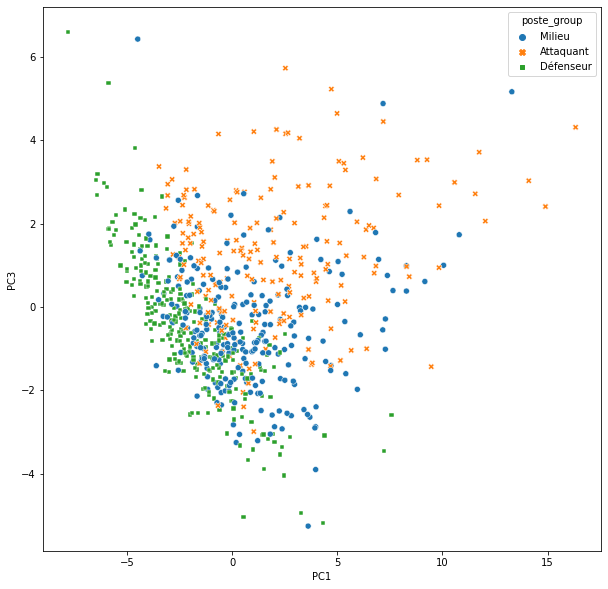

In [30]:
f, ax = plt.subplots(figsize=(10,10))
df_sub=dfRest_final[:1000]

g=sns.scatterplot(df_sub, x="PC1", y="PC3", hue="poste_group", style = 'poste_group')

#for index, row in df_sub.iterrows():
#    x, y = row["PC1"],row["PC3"]    
#    ax.text(x, y, s=row["player_name"], size=12, zorder=1, color='k')

# Suggestion Algorithm

As we want to determine which player is the most similar (the clothest in the PCA graph) of the given player, a first approach could be calculating its nearest neighbors

## K-Nearest neighbors

In [31]:
nbrsGK = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nbrsGK.fit(dfGK_scaler.drop('id',axis=1))
nbrsRest = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nbrsRest.fit(dfRest_scaler.drop('id',axis=1))


NearestNeighbors(algorithm='ball_tree')

In [32]:
indicesRest = nbrsRest.kneighbors(dfRest_scaler.drop('id',axis=1), return_distance=False)
dfRest_Indices=pd.concat([pd.DataFrame(dfRest_scaler, columns=["id"]), pd.DataFrame(indicesRest)], axis=1).set_index('id').drop(0, axis=1)

indicesGK = nbrsGK.kneighbors(dfGK_scaler.drop('id',axis=1), return_distance=False)
dfGK_Indices=pd.concat([pd.DataFrame(dfGK_scaler, columns=["id"]), pd.DataFrame(indicesGK)], axis=1).set_index('id').drop(0,axis=1)

dfRest_Indices

def lineToIndex(x, df):
    return df['id'].iloc[x]

for i in range(1,5):
    dfRest_Indices[i]=dfRest_Indices[i].apply(lineToIndex, args=[dfRest])
    dfGK_Indices[i]=dfGK_Indices[i].apply(lineToIndex, args=[dfGK])

In [33]:
def value_player(x):
    return df[df['id']==x]['value'].iloc[0]


def get_suggestion(name):
    ind=df[df["player_name"]==name]['id'].iloc[0]
    if df[df["player_name"]==name]["Poste"].iloc[0]!="Gardient de but":
        #work with Rest dataset
        nbrs_list=dfRest_Indices.loc[ind]
        dff=pd.DataFrame(nbrs_list)
        dff.columns=["nbrs"]
        dff["value"]=dff['nbrs'].apply(value_player)

        return df[df["player_name"]==name], dff    

Let's try with Cristiano Ronaldo, one of the best striker of premier league

In [34]:
nbrs_list=dfRest_Indices.loc[2371].to_list()
for nbr in nbrs_list:
    print(f"{df[df['id']==nbr]['player_name'].iloc[0]}: {df[df['id']==nbr]['value'].iloc[0]}" )

Sadio Mané: 60,00 mio. €
Alassane Pléa: 15,00 mio. €
Diogo Jota: 55,00 mio. €
Raheem Sterling: 70,00 mio. €


Results are good, we have a selection of top attack scorer available, with their market value

In [35]:
get_suggestion("Cristiano Ronaldo")[1]

,nbrs,value
1,838,"60,00 mio. €"
2,3310,"15,00 mio. €"
3,6854,"55,00 mio. €"
4,618,"70,00 mio. €"


## KMeans

Let's try to upgrade our clustering model with a decision tree: it could be interesting to get decision rules, so that we have commun caracteristic between a player and it's predictions

As the player are not labels (into catories), we need to create our own clusters, and labels them. Then, we will create a decision tree to get the decision rules, to have an overview of caracteristics of players from the same cluster

In [36]:
kmeansRest = KMeans(n_clusters=13)
kmeansRest.fit(dfRest_pca.drop('id', axis=1))
kmeansRest.labels_

df_kmeansRest=pd.DataFrame(dfRest_pca['id'].copy())
df_kmeansRest['cluster']=kmeansRest.labels_

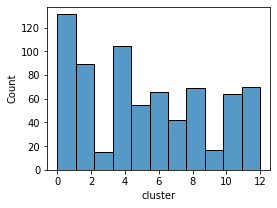

In [37]:
f, ax = plt.subplots(figsize=(4, 3))
g8=sns.histplot(x='cluster', data=df_kmeansRest)

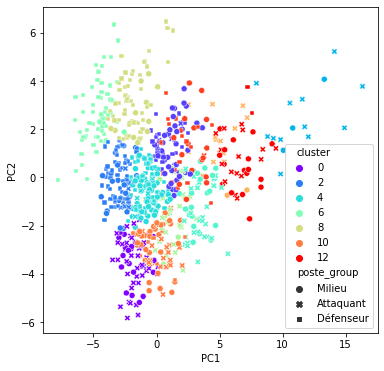

In [38]:
f, ax = plt.subplots(figsize=(6,6))
df_sub=dfRest_final.copy()
df_sub=pd.merge(df_sub, df_kmeansRest, on='id')
df_sub
g=sns.scatterplot(df_sub, x="PC1", y="PC2", hue="cluster", style = 'poste_group', palette="rainbow")

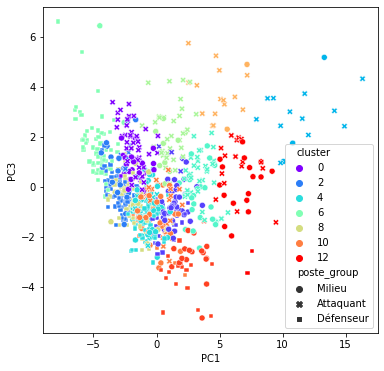

In [39]:
f, ax = plt.subplots(figsize=(6,6))
df_sub=dfRest_final.copy()
df_sub=pd.merge(df_sub, df_kmeansRest, on='id')
df_sub
g=sns.scatterplot(df_sub, x="PC1", y="PC3", hue="cluster", style = 'poste_group', palette="rainbow")

## Decision Tree

As a decision tree (classifier or regression) is working with a target value, we will take the predicted clusters from the Kmeans

In [241]:
dfRestLabeled=pd.merge(dfRest_features, df_kmeansRest, on='id')
dfRestLabeled.head()

,id,player_international,age_actuel,taille_en_m,poste_cat,time,goals,xG,assists,xA,...,Agility,Penalties,Volleys,Jumping,Heading,Curve,Finishing,power_cat,value_int,cluster
0,942,1,29,179,4,2973,22,17.187835,11,13.008778,...,84.0,78.0,75.0,76.0,70.0,84.0,72.0,0,1.000000e+09,4
1,555,1,28,178,6,2569,19,13.003762,13,7.758003,...,80.0,76.0,75.0,69.0,65.0,85.0,84.0,0,2.000000e+09,4
2,2099,1,30,175,6,1797,19,16.537807,13,12.280965,...,93.0,91.0,86.0,62.0,63.0,88.0,83.0,0,7.500000e+09,4
3,1817,1,32,189,6,2289,18,14.911137,1,3.062690,...,68.0,91.0,78.0,72.0,72.0,76.0,80.0,2,2.000000e+08,12
4,3667,1,29,173,4,2488,18,11.944972,8,7.036876,...,85.0,74.0,77.0,64.0,49.0,83.0,83.0,2,4.000000e+09,4


In [242]:
XRest=dfRestLabeled.drop(['cluster'], axis=1)
yRest=dfRestLabeled['cluster']

X_train, X_test, y_train, y_test = train_test_split(XRest, yRest, test_size=0.2)

In [243]:
param_space = hp.choice('classifier_type', [
    {
        'max_depth': hp.quniform('max_depth', 2, 15, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
    }
])

In [244]:
# Define the objective function that will be minimized
def objective(params):
    params = {'max_depth': int(params['max_depth']),
    'min_samples_split': int(params['min_samples_split']),
    'min_samples_leaf': int(params['min_samples_leaf'])}
    
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    scores = model.score(X_test, y_test)
    return 1-cross_val_score(model, XRest, yRest).mean()

# Run the optimization
best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=1000)

# Print the best hyperparameters
best_params = {'max_depth': int(best['max_depth']),
                'min_samples_split': int(best['min_samples_split']),
                'min_samples_leaf': int(best['min_samples_leaf'])}
print(best_params)

# Re-train the model with the best hyperparameters
model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)
model.score(X_test, y_test)


  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

2023-01-22 16:12:25.573 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008020 seconds
2023-01-22 16:12:25.581 INFO    hyperopt.tpe: TPE using 0 trials


  0%|          | 1/1000 [00:00<07:52,  2.12trial/s, best loss: 0.5912835249042145]

2023-01-22 16:12:26.053 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008054 seconds
2023-01-22 16:12:26.061 INFO    hyperopt.tpe: TPE using 1/1 trials with best loss 0.591284


  0%|          | 2/1000 [00:00<08:06,  2.05trial/s, best loss: 0.5898946360153257]

2023-01-22 16:12:26.551 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016007 seconds
2023-01-22 16:12:26.559 INFO    hyperopt.tpe: TPE using 2/2 trials with best loss 0.589895


  0%|          | 3/1000 [00:01<08:42,  1.91trial/s, best loss: 0.45688697318007665]

2023-01-22 16:12:27.119 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015918 seconds
2023-01-22 16:12:27.128 INFO    hyperopt.tpe: TPE using 3/3 trials with best loss 0.456887


  0%|          | 4/1000 [00:02<09:05,  1.82trial/s, best loss: 0.4292337164750958] 

2023-01-22 16:12:27.696 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008006 seconds
2023-01-22 16:12:27.704 INFO    hyperopt.tpe: TPE using 4/4 trials with best loss 0.429234


  0%|          | 5/1000 [00:02<09:21,  1.77trial/s, best loss: 0.4292337164750958]

2023-01-22 16:12:28.296 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016078 seconds
2023-01-22 16:12:28.296 INFO    hyperopt.tpe: TPE using 5/5 trials with best loss 0.429234


  1%|          | 6/1000 [00:03<09:49,  1.69trial/s, best loss: 0.4292337164750958]

2023-01-22 16:12:28.938 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015963 seconds
2023-01-22 16:12:28.946 INFO    hyperopt.tpe: TPE using 6/6 trials with best loss 0.429234


  1%|          | 7/1000 [00:04<10:14,  1.62trial/s, best loss: 0.4292337164750958]

2023-01-22 16:12:29.618 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016004 seconds
2023-01-22 16:12:29.618 INFO    hyperopt.tpe: TPE using 7/7 trials with best loss 0.429234


  1%|          | 8/1000 [00:04<10:11,  1.62trial/s, best loss: 0.4292337164750958]

2023-01-22 16:12:30.219 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015934 seconds
2023-01-22 16:12:30.227 INFO    hyperopt.tpe: TPE using 8/8 trials with best loss 0.429234


  1%|          | 9/1000 [00:05<10:00,  1.65trial/s, best loss: 0.4278448275862069]

2023-01-22 16:12:30.804 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015793 seconds
2023-01-22 16:12:30.813 INFO    hyperopt.tpe: TPE using 9/9 trials with best loss 0.427845


  1%|          | 10/1000 [00:05<09:55,  1.66trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:31.395 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007092 seconds
2023-01-22 16:12:31.403 INFO    hyperopt.tpe: TPE using 10/10 trials with best loss 0.425105


  1%|          | 11/1000 [00:06<09:59,  1.65trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:32.019 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016081 seconds
2023-01-22 16:12:32.019 INFO    hyperopt.tpe: TPE using 11/11 trials with best loss 0.425105


  1%|          | 12/1000 [00:07<10:08,  1.62trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:32.651 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008132 seconds
2023-01-22 16:12:32.659 INFO    hyperopt.tpe: TPE using 12/12 trials with best loss 0.425105


  1%|▏         | 13/1000 [00:07<10:25,  1.58trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:33.333 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016170 seconds
2023-01-22 16:12:33.333 INFO    hyperopt.tpe: TPE using 13/13 trials with best loss 0.425105


  1%|▏         | 14/1000 [00:08<09:08,  1.80trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:33.701 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015989 seconds
2023-01-22 16:12:33.709 INFO    hyperopt.tpe: TPE using 14/14 trials with best loss 0.425105


  2%|▏         | 15/1000 [00:08<09:15,  1.77trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:34.285 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008017 seconds
2023-01-22 16:12:34.293 INFO    hyperopt.tpe: TPE using 15/15 trials with best loss 0.425105


  2%|▏         | 16/1000 [00:09<09:40,  1.70trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:34.941 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016005 seconds
2023-01-22 16:12:34.949 INFO    hyperopt.tpe: TPE using 16/16 trials with best loss 0.425105


  2%|▏         | 17/1000 [00:10<10:08,  1.62trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:35.621 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007944 seconds
2023-01-22 16:12:35.637 INFO    hyperopt.tpe: TPE using 17/17 trials with best loss 0.425105


  2%|▏         | 18/1000 [00:10<10:18,  1.59trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:36.285 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015984 seconds
2023-01-22 16:12:36.293 INFO    hyperopt.tpe: TPE using 18/18 trials with best loss 0.425105


  2%|▏         | 19/1000 [00:11<10:39,  1.53trial/s, best loss: 0.42510536398467436]

2023-01-22 16:12:36.989 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015999 seconds
2023-01-22 16:12:36.997 INFO    hyperopt.tpe: TPE using 19/19 trials with best loss 0.425105


  2%|▏         | 20/1000 [00:12<10:45,  1.52trial/s, best loss: 0.4209386973180076] 

2023-01-22 16:12:37.661 INFO    hyperopt.tpe: build_posterior_wrapper took 0.015970 seconds
2023-01-22 16:12:37.669 INFO    hyperopt.tpe: TPE using 20/20 trials with best loss 0.420939


  2%|▏         | 21/1000 [00:12<11:14,  1.45trial/s, best loss: 0.4209386973180076]

2023-01-22 16:12:38.421 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016013 seconds
2023-01-22 16:12:38.429 INFO    hyperopt.tpe: TPE using 21/21 trials with best loss 0.420939


  2%|▏         | 22/1000 [00:13<12:31,  1.30trial/s, best loss: 0.4209386973180076]

2023-01-22 16:12:39.374 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016015 seconds
2023-01-22 16:12:39.374 INFO    hyperopt.tpe: TPE using 22/22 trials with best loss 0.420939


  2%|▏         | 23/1000 [00:14<11:55,  1.37trial/s, best loss: 0.4209386973180076]

2023-01-22 16:12:40.014 INFO    hyperopt.tpe: build_posterior_wrapper took 0.016006 seconds
2023-01-22 16:12:40.022 INFO    hyperopt.tpe: TPE using 23/23 trials with best loss 0.420939


  2%|▏         | 24/1000 [00:15<11:46,  1.38trial/s, best loss: 0.4209386973180076]

2023-01-22 16:12:40.728 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007971 seconds
2023-01-22 16:12:40.736 INFO    hyperopt.tpe: TPE using 24/24 trials with best loss 0.420939


  2%|▏         | 24/1000 [00:15<10:35,  1.54trial/s, best loss: 0.4209386973180076]


KeyboardInterrupt: 

In [246]:
tree = DecisionTreeClassifier(max_depth=8,
                            min_samples_split=7,
                            min_samples_leaf=1
                            )
tree.fit(X_train, y_train)

# Obtain the decision rules from the model
#feat_noId=features.remove('id')
tree.score(X_test, y_test)

0.5586206896551724

In [247]:
varImp=pd.DataFrame(model.feature_importances_)
varImp.columns=['Importance']
varImp=varImp.T
varImp.columns=features
varImp=varImp.T
varImp=varImp.sort_values('Importance', ascending=False)

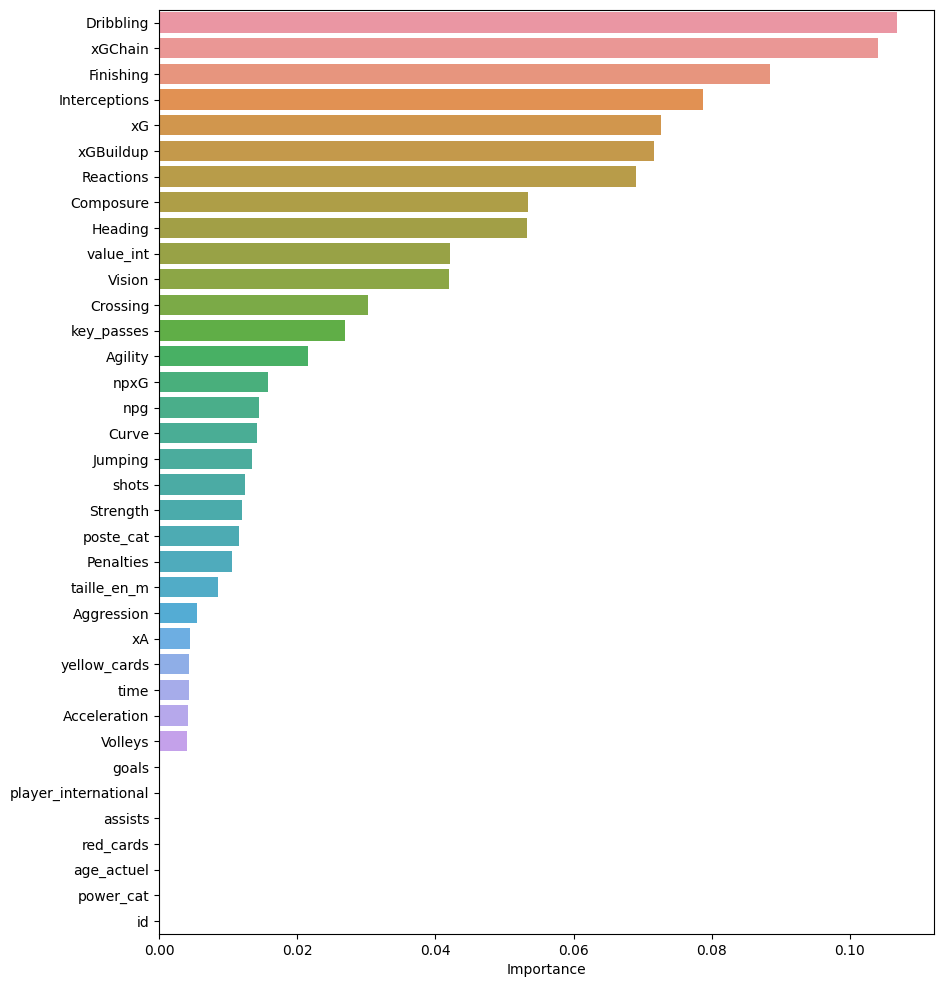

In [92]:
f, ax = plt.subplots(figsize=(10, 12))
g8=sns.barplot(y=varImp.index, x='Importance', data=varImp, orient='h')

We will only keep in consideration the first 7 most important variables

In [159]:
top7Rest=varImp[:7].index.to_list()
top7Rest

['Dribbling',
 'xGChain',
 'Finishing',
 'Interceptions',
 'xG',
 'xGBuildup',
 'Reactions']

# Final ouput

In [57]:
df=pd.read_csv("dfApp.csv")
dfGK_Indices=pd.read_csv("dfApp_GK.csv")
dfRest_Indices=pd.read_csv("dfApp_Rest.csv")

In [58]:
dfRest_Indices=dfRest_Indices
dfRest_Indices

,1,2,3,4
id,,,,
942,555,1250,2099,1776
555,942,1776,7768,3310
2099,1250,942,647,555
1817,3667,3512,3228,3477
3667,1817,555,1776,8026
...,...,...,...,...
10174,9833,10091,9554,6377
10177,9690,8868,4932,6395
10203,9415,9492,10036,6492


In [63]:
def value_player(x):
    return df[df['id']==x]['value'].iloc[0]

def value_player_1(x):
    return df[df['id']==x]['Dribbling'].iloc[0]

def value_player_2(x):
    return df[df['id']==x]['xGChain'].iloc[0]

def value_player_3(x):
    return df[df['id']==x]['Finishing'].iloc[0]

def value_player_4(x):
    return df[df['id']==x]['Interceptions'].iloc[0]

def value_player_5(x):
    return df[df['id']==x]['xG'].iloc[0]

def value_player_6(x):
    return df[df['id']==x]['player_name'].iloc[0]


def get_suggestion_v2(name):
    ind=df[df["player_name"]==name]['id'].iloc[0]
    if df[df["player_name"]==name]["Poste"].iloc[0]!="Gardien de but":
        #work with Rest dataset
        nbrs_list=dfRest_Indices.loc[ind]
        dff=pd.DataFrame(nbrs_list)
        dff.columns=["nbrs"]
        dff["value"]=dff['nbrs'].apply(value_player)
        dff["Dribbling"]=dff['nbrs'].apply(value_player_1)
        dff["xGChain"]=dff['nbrs'].apply(value_player_2)
        dff["Finishing"]=dff['nbrs'].apply(value_player_3)
        dff["Interceptions"]=dff['nbrs'].apply(value_player_4)
        dff["xG"]=dff['nbrs'].apply(value_player_5)
        dff["player_name"]=dff['nbrs'].apply(value_player_6)
    
    else:
        nbrs_list=dfGK_Indices.loc[1670]
        dff=pd.DataFrame(nbrs_list)
        dff.columns=["nbrs"]
        dff["value"]=dff['nbrs'].apply(value_player)
        dff["player_name"]=dff['nbrs'].apply(value_player_6)

    output=df[df["player_name"]==name], dff
    return output

In [64]:
get_suggestion_v2("Neymar")[1]

KeyError: 'player_name'

In [276]:
df.to_csv("dfApp.csv")
dfGK_Indices.to_csv("dfApp_GK.csv")
dfRest_Indices.to_csv("dfApp_Rest.csv")

In [279]:
df.columns

Index(['Unnamed: 0', 'player_international', 'number', 'Nationalite',
       'mois_de_naissance', 'jour_de_naissance', 'anne_de_naissance',
       'age_actuel', 'taille_en_m', 'Poste', 'Pied_fort', 'id', 'player_name',
       'time', 'goals', 'xG', 'assists', 'xA', 'shots', 'key_passes',
       'yellow_cards', 'red_cards', 'position', 'team_title', 'npg', 'npxG',
       'xGChain', 'xGBuildup', 'Dribbling', 'Marking', 'Aggression',
       'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing',
       'Acceleration', 'Strength', 'Agility', 'Penalties', 'Volleys', 'Power',
       'Jumping', 'Heading', 'Curve', 'Injury', 'Finishing', 'value',
       'dateDeNaissance', 'Pied_fort_cat', 'value_int', 'poste_cat',
       'power_cat', 'poste_group'],
      dtype='object')

In [61]:
df.columns

Index(['Unnamed: 0', 'player_international', 'number', 'Nationalite',
       'mois_de_naissance', 'jour_de_naissance', 'anne_de_naissance',
       'age_actuel', 'taille_en_m', 'Poste', 'Pied_fort', 'id', 'player_name',
       'time', 'goals', 'xG', 'assists', 'xA', 'shots', 'key_passes',
       'yellow_cards', 'red_cards', 'position', 'team_title', 'npg', 'npxG',
       'xGChain', 'xGBuildup', 'Dribbling', 'Marking', 'Aggression',
       'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing',
       'Acceleration', 'Strength', 'Agility', 'Penalties', 'Volleys', 'Power',
       'Jumping', 'Heading', 'Curve', 'Injury', 'Finishing', 'value',
       'dateDeNaissance', 'Pied_fort_cat', 'value_int', 'poste_cat',
       'power_cat', 'poste_group'],
      dtype='object')